In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')

In [2]:
class GlobalStreetscapesSample(Dataset):
    def __init__(self, dataset):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        label = int(self.img_labels.iloc[idx].loc["label"])
        image = self.resize(image)
        return image, label

In [3]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:",samples.shape[0])
print("paths rows:",paths.shape[0])
print("img_labels rows:",img_labels.shape[0])

train_ratio = 0.8
train_df, test_df = train_test_split(img_labels, train_size=train_ratio, stratify=img_labels['label'])

display(train_df.head())

training_data = GlobalStreetscapesSample(
    train_df
)

test_data = GlobalStreetscapesSample(
    test_df
)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True, num_workers=16, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True, num_workers=16, pin_memory=True)

samples rows: 187726
paths rows: 200632
img_labels rows: 187723


,uuid,source,orig_id,city,country,iso3,s2_cell_id,label,lat,lon,path
75561,4b85800a-b8f4-47b5-bfef-a06a3a5701ab,Mapillary,515568262818627,Washington,United States,USA,9.923602e+18,15,38.904202,-77.021972,../data/imgs/24dac46f-59d0-474d-bd5a-0b7657d5e...
49455,757ca19d-1cf0-457b-9c7b-6032b863abd6,Mapillary,1446756988995282,Washington,United States,USA,9.923602e+18,22,38.900383,-77.029505,../data/imgs/6213fb4b-213d-432b-92a9-abaca223d...
186758,6e042271-5fc3-4eb9-9987-1e93bee49c73,Mapillary,469522721692605,Washington,United States,USA,9.923602e+18,51,38.901343,-77.016500,../data/imgs/617e9c7c-c70c-4c98-865b-b51a69e86...
29799,c9ce364d-8bfa-43d8-bb66-c08a87f80970,Mapillary,583942599244479,Washington,United States,USA,9.923603e+18,43,38.905972,-77.023944,../data/imgs/0a6ee0bc-bb05-42e2-8081-a04230748...
44561,c3f03c3d-6cae-4a34-a237-3b73302f2e45,Mapillary,4565591346787775,Washington,United States,USA,9.923602e+18,25,38.901075,-77.026989,../data/imgs/6213fb4b-213d-432b-92a9-abaca223d...


Washington


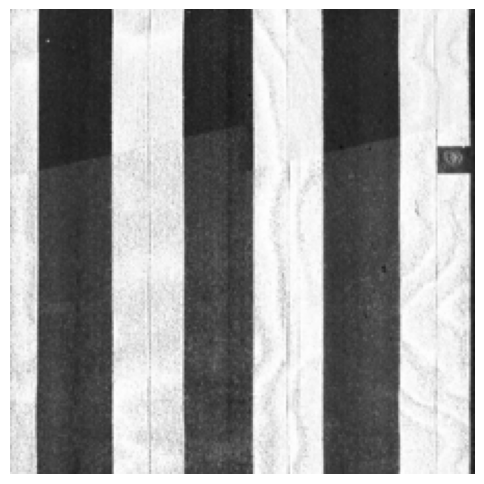

In [4]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
print(training_data.img_labels.iloc[10].loc["city"])
img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6,10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
# Base Vision Transformer Docs: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# VIT_B_16 Docs: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html
weights = ViT_B_16_Weights.IMAGENET1K_V1
transform = weights.transforms()

model = vit_b_16(weights=weights)

in_features = model.heads.head.in_features
num_classes = img_labels.label.nunique()

# Replace the default number of classes
print(f"Previous head: {model.heads.head}")
model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)
model.num_classes = num_classes
print(f"Previous head: {model.heads.head}")
print(f"Number of classes: {model.num_classes}")

model = model.to(device=device)
model = torch.compile(model)
print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:00<00:00, 475MB/s] 


Previous head: Linear(in_features=768, out_features=1000, bias=True)
Previous head: Linear(in_features=768, out_features=62, bias=True)
Number of classes: 62
Using device: cuda


In [6]:
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Changed to OneCycleLR with 10% warmup
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs,
    pct_start=0.1  # 10% of total steps used for warmup
)

train_loss = 0
for epoch in range(num_epochs):
    print(f"EPOCH: {epoch+1}")

    current_loss = 0
    model.train()
    for inputs, labels in tqdm(train_dataloader):
        # Move to GPU with non_blocking for better performance
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step() # Moved inside the batch loop for OneCycleLR
        
        current_loss += loss.item()
    
    avg_train_loss = current_loss / len(train_dataloader)
    train_loss += avg_train_loss
    print(f"Loss: {avg_train_loss:.3f} ({train_loss / (epoch+1):.3f})")
    # Print current LR to verify schedule
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    torch.save(model.state_dict(), f'vit_b_16_base_epoch{epoch}.pth')

EPOCH: 1


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 3.177 (3.177)
LR: 0.000052
EPOCH: 2


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 1.856 (2.516)
LR: 0.000100
EPOCH: 3


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 1.434 (2.156)
LR: 0.000099
EPOCH: 4


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 1.201 (1.917)
LR: 0.000097
EPOCH: 5


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 1.055 (1.745)
LR: 0.000093
EPOCH: 6


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.944 (1.611)
LR: 0.000088
EPOCH: 7


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.870 (1.505)
LR: 0.000082
EPOCH: 8


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.816 (1.419)
LR: 0.000075
EPOCH: 9


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.785 (1.349)
LR: 0.000067
EPOCH: 10


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.769 (1.291)
LR: 0.000059
EPOCH: 11


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.753 (1.242)
LR: 0.000050
EPOCH: 12


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.743 (1.200)
LR: 0.000041
EPOCH: 13


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.736 (1.165)
LR: 0.000033
EPOCH: 14


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.732 (1.134)
LR: 0.000025
EPOCH: 15


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.729 (1.107)
LR: 0.000018
EPOCH: 16


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.728 (1.083)
LR: 0.000012
EPOCH: 17


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.728 (1.062)
LR: 0.000007
EPOCH: 18


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.728 (1.044)
LR: 0.000003
EPOCH: 19


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.728 (1.027)
LR: 0.000001
EPOCH: 20


  0%|          | 0/587 [00:00<?, ?it/s]

Loss: 0.728 (1.012)
LR: 0.000000


In [7]:
# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='s', label='Validation Loss')
plt.title('Training vs Validation Loss over Epochs - Vit-B/16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1000x600 with 0 Axes>

In [8]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {accuracy:.2f}%")

  0%|          | 0/147 [00:00<?, ?it/s]

Test Loss: 1.255
Test Accuracy: 85.00%


In [9]:
import matplotlib.pyplot as plt
import os
import torch
import pandas as pd

# Define criterion here since the training cell was skipped
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

#  Parse Training Loss from Logs
log_data = """
EPOCH: 1
Loss: 3.177 (3.177)
EPOCH: 2
Loss: 1.856 (2.516)
EPOCH: 3
Loss: 1.434 (2.156)
EPOCH: 4
Loss: 1.201 (1.917)
EPOCH: 5
Loss: 1.055 (1.745)
EPOCH: 6
Loss: 0.944 (1.611)
EPOCH: 7
Loss: 0.870 (1.505)
EPOCH: 8
Loss: 0.816 (1.419)
EPOCH: 9
Loss: 0.785 (1.349)
EPOCH: 10
Loss: 0.769 (1.291)
EPOCH: 11
Loss: 0.753 (1.242)
EPOCH: 12
Loss: 0.743 (1.200)
EPOCH: 13
Loss: 0.736 (1.165)
EPOCH: 14
Loss: 0.732 (1.134)
EPOCH: 15
Loss: 0.729 (1.107)
EPOCH: 16
Loss: 0.728 (1.083)
EPOCH: 17
Loss: 0.728 (1.062)
EPOCH: 18
Loss: 0.728 (1.044)
EPOCH: 19
Loss: 0.728 (1.027)
EPOCH: 20
Loss: 0.728 (1.012)
"""

epochs = []
train_losses = []

for line in log_data.strip().split('\n'):
    if line.startswith("EPOCH:"):
        epochs.append(int(line.split(":")[1].strip()))
    elif line.startswith("Loss:"):
        loss_val = float(line.split()[1])
        train_losses.append(loss_val)

# Retroactively Calculate Validation Loss
val_losses = []
print("Calculating validation loss for saved checkpoints...")

# Ensure model is in eval mode
model.eval()

# Iterate through the 20 epochs (0 to 19 in filenames)
for epoch_idx in range(20):
    checkpoint_path = f'vit_b_16_base_epoch{epoch_idx}.pth'
    
    if not os.path.exists(checkpoint_path):
        print(f"Warning: {checkpoint_path} not found. Skipping.")
        val_losses.append(None)
        continue
        
    # Load weights
    # We use strict=False just in case of any minor compilation artifacts, though usually not needed
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader, desc=f"Epoch {epoch_idx+1} Val", leave=False):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            inputs = transform(inputs)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
    avg_val_loss = running_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch_idx+1} Validation Loss: {avg_val_loss:.3f}")

# Save to DataFrame
loss_history = pd.DataFrame({
    'epoch': epochs,
    'train_loss': train_losses,
    'val_loss': val_losses
})

print("Loss history saved to 'loss_history' DataFrame.")
display(loss_history.head())

Calculating validation loss for saved checkpoints...


Epoch 1 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 2.163


Epoch 2 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 1.678


Epoch 3 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 1.453


Epoch 4 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 1.407


Epoch 5 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 1.356


Epoch 6 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 1.345


Epoch 7 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 1.327


Epoch 8 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 1.308


Epoch 9 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 1.332


Epoch 10 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 1.299


Epoch 11 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 11 Validation Loss: 1.302


Epoch 12 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 12 Validation Loss: 1.281


Epoch 13 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 13 Validation Loss: 1.255


Epoch 14 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 14 Validation Loss: 1.238


Epoch 15 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 15 Validation Loss: 1.239


Epoch 16 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 16 Validation Loss: 1.245


Epoch 17 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 17 Validation Loss: 1.250


Epoch 18 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 18 Validation Loss: 1.253


Epoch 19 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 19 Validation Loss: 1.255


Epoch 20 Val:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 20 Validation Loss: 1.255
Loss history saved to 'loss_history' DataFrame.


,epoch,train_loss,val_loss
0,1,3.177,2.162507
1,2,1.856,1.678330
2,3,1.434,1.452787
3,4,1.201,1.406697
4,5,1.055,1.356355


In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(loss_history['epoch'], loss_history['train_loss'], marker='o', label='Training Loss')
plt.plot(loss_history['epoch'], loss_history['val_loss'], marker='s', label='Validation Loss')

plt.title('Training vs Validation Loss over Epochs - ViT-B/16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()